In [1]:
import os
os.chdir('..')
# os.chdir(os.path.dirname(__file__))
print(os.getcwd())

/workspace/rendering


/root/anaconda3/envs/grabnet/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


handBeta [-0.8101279  -0.77720827 -1.9707527  -0.35107753 -0.64986867 -2.711966
  1.1160069  -0.6333117   0.75000185 -0.4505857 ]
handTrans [-0.17314191  0.033498   -0.4139921 ]
handPose [-4.9477720e-01 -2.9084916e+00 -1.0624030e+00  6.8812437e-02
 -6.0573786e-02  3.2234587e-02 -4.4735207e-04  4.3422660e-19
  8.6854346e-02 -6.0234931e-03 -7.7093321e-19  3.0615541e-01
  5.6171227e-02  1.9258326e-02  1.0536692e-01 -3.2234408e-02
 -1.4398715e-17  1.8810405e-01 -6.9702595e-02 -1.8588173e-17
  3.4126335e-01 -6.0398415e-02  3.0366975e-01  3.9802048e-01
 -2.9513856e-02  2.4043223e-02  4.8609186e-02 -2.5002738e-02
  2.2474837e-02  4.6910923e-02 -1.6872741e-01 -1.2718353e-02
  3.5431588e-01 -2.2356899e-02 -2.7889159e-17  7.0105672e-02
 -4.0142499e-02  1.5663930e-17  1.3455027e-01  4.6667641e-01
 -2.2782271e-01  5.9929222e-01 -2.6677474e-03  7.1702977e-03
 -4.3789321e-03  1.0868779e-02 -2.6867662e-02  1.5843730e-02]
handJoints3D [[-0.07221958  0.03996737 -0.40746005]
 [ 0.01549277  0.02175211 -0

/workspace/rendering/utils/utils.py:24: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if v is None or v == 'None':


torch.int32
tensor([[614.6270,   0.0000, 320.2620],
        [  0.0000, 614.1010, 238.4690],
        [  0.0000,   0.0000,   1.0000]])
tensor(55.0067)
{'position': tensor([0., 0., 0.]), 'look_at': tensor([ 0.,  0., -1.]), 'up': tensor([0., 1., 0.]), '_fov': None, '_cam_to_world': None, 'world_to_cam': None, '_intrinsic_mat': tensor([[ 1.9207e+00,  0.0000e+00,  4.0936e-04],
        [ 0.0000e+00,  1.9191e+00, -3.1896e-03],
        [ 0.0000e+00,  0.0000e+00,  1.0000e+00]]), 'intrinsic_mat_inv': tensor([[ 5.2064e-01,  0.0000e+00, -2.1313e-04],
        [ 0.0000e+00,  5.2109e-01,  1.6621e-03],
        [ 0.0000e+00,  0.0000e+00,  1.0000e+00]]), 'distortion_params': None, 'clip_near': 0.0001, 'resolution': (480, 640), 'viewport': None, 'camera_type': CameraType.perspective}
torch.Size([7866, 3]) torch.Size([3, 3]) torch.Size([3])


/root/anaconda3/envs/grabnet/lib/python3.9/site-packages/pyredner/render_pytorch.py:214: UserWarning: Converting shape vertices from cpu to cuda:0, this can be inefficient.
  warnings.warn('Converting shape vertices from {} to {}, this can be inefficient.'.format(shape.vertices.device, device))
/root/anaconda3/envs/grabnet/lib/python3.9/site-packages/pyredner/render_pytorch.py:216: UserWarning: Converting shape indices from cpu to cuda:0, this can be inefficient.
  warnings.warn('Converting shape indices from {} to {}, this can be inefficient.'.format(shape.indices.device, device))


Scene construction, time: 0.06791 s
Forward pass, time: 0.09745 s


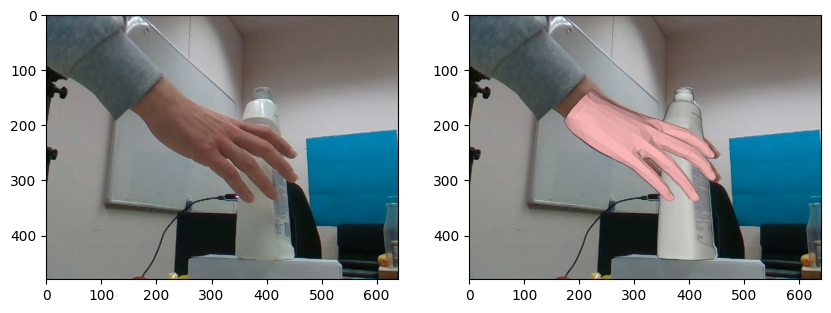

In [2]:
import pyredner # pyredner will be the main Python module we import for redner.
import torch # We also import PyTorch
from PIL import Image
import numpy as np
from matplotlib.pyplot import imshow
from utils.utils import load_ho_meta, apply_transform_to_mesh
from utils.mano import ManoLayer


bg_img = np.array(Image.open('data/HO3D_v3/train/ABF10/rgb/0000.jpg'), dtype=np.float32)/255.0
anno = load_ho_meta('data/HO3D_v3/train/ABF10/meta/0000.pkl')
mano = ManoLayer()
# mano_verts = mano(anno)
mano_hand = mano(anno)

resolution = bg_img.shape[:2]

mano_object = pyredner.Object(
    # vertices=mano_verts[0], 
    vertices=mano_hand.vertices[0], 
    indices=mano.faces, 
    uvs=mano.uv,
    material=pyredner.Material(
        diffuse_reflectance=pyredner.Texture(mano.map.to(pyredner.get_device()))
        # diffuse_reflectance=torch.tensor((0.5, 0.5, 0.5), device=pyredner.get_device())))
    )
)
print(mano.faces.dtype)

world2cam = torch.eye(4)
R = torch.diag(torch.tensor([-1.,1.,-1.]))
world2cam[:3,:3] = R
cam2world = world2cam.inverse()
K = torch.tensor(anno['camMat'], dtype=torch.float32)
fx, fy = K.diagonal()[:2]
px, py = K[:2,2]
print(K)
intrinsic_mat = torch.tensor([
        [fx / resolution[1] * 2, 0.0000, px/resolution[1]-0.5],
        [0.0000, fy / resolution[1] * 2, py/resolution[0]-0.5],
        [0.0000, 0.0000, 1.0000]]
        )

fov = 2* torch.atan(0.5 * resolution[1] / K[0, 0]) * 180 / 3.1415926
print(fov)
camera = pyredner.Camera(
    intrinsic_mat=intrinsic_mat,
    # cam_to_world=cam2world,
    position = torch.tensor([0, 0, 0.], dtype=torch.float32),
    look_at = torch.tensor([0, 0, -1.], dtype=torch.float32),
    up = torch.tensor([0, 1., 0], dtype=torch.float32),
    # fov = torch.tensor([fov], dtype=torch.float32),
    resolution=resolution,
)
print(camera.__dict__)
dirlight = pyredner.DirectionalLight(
    direction = torch.tensor([0.0, 0.0, -1.0]), 
    intensity = torch.ones(3)*3.0,
)
# envmap = pyredner.EnvironmentMap(torch.tensor(bg_img))

objects = pyredner.load_obj('data/models/021_bleach_cleanser/textured_simple.obj', return_objects=True)
obj_object = pyredner.Object(
    vertices=apply_transform_to_mesh(objects[0].vertices, anno),
    indices=objects[0].indices, 
    uvs=objects[0].uvs,
    uv_indices=objects[0].uv_indices,
    material=objects[0].material
)

# create scene
scene = pyredner.Scene(
    camera = camera, 
    objects = [
        mano_object, 
        obj_object,
        ]
    )

# Render the scene.
# render = pyredner.render_albedo(scene, alpha=True)
render = pyredner.render_deferred(scene, lights=[dirlight], alpha=True)
    

import matplotlib.pyplot as plt

fig, axs = plt.subplots(1, 2, figsize=(10, 5))
axs[0].imshow(bg_img)
axs[1].imshow(bg_img)
axs[1].imshow(torch.pow(render, 1.0/2.2).cpu())

In [ ]:
# 1/ (0.5 * resolution[1] / K[0, 0])
fx / resolution[1] * 2

tensor(1.9207)